In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Notation

This notebook solves $\frac{\mathrm{d}^2 x}{\mathrm{d}t^2} = F$, for constant $F$.

This equation does, of course, have a 2D space of solutions. This notebook finds the solution that minimizes the $L^2$ norm between the solution and a set of datapoints.

# Parameters

In [2]:
# You can edit anything in this cell.
# If you do so, you should re-run the whole notebook.

h = 0.01  # Grid resolution
rng_seed_data = 1234  # Used for data generation
sigma = 0.0  # Noise level for data generation
N_samples = 10  # Number of datapoints to 'measure' from the 'true' curve
F = -10  # Force. Constant in this version. Chosen to be close to free-fall in SI units.

x0 = 0.5  # Initial condition for the true solution.
v0 = 0.1  # Initial condition for the true solution.

# Data generation

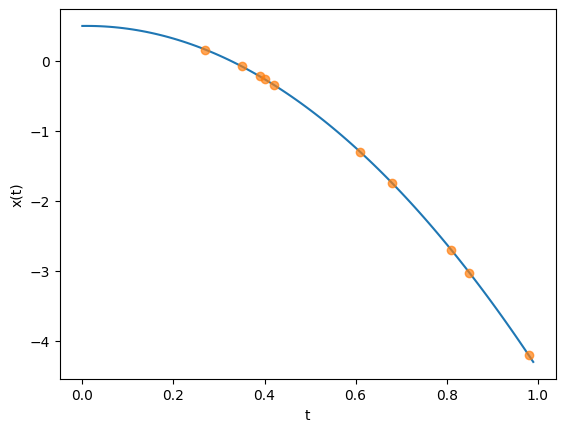

In [3]:
t_grid = np.arange(0, 1, h)  # Useful to have this for plotting.
N_grid = t_grid.shape[0]  # Number of points in this discretized grid over t.
x_true_grid = x0 + t_grid*v0 + 0.5*F*t_grid**2  # True solution curve.

rng_data = np.random.RandomState(rng_seed_data)  # Instantiate the RNG in the same cell that we will do all the calls.
idx_samples = rng_data.choice(N_grid, size=N_samples, replace=False)  # Choose which datapoints will will 'measure'
idx_samples = np.sort(idx_samples)
x_noise = rng_data.normal(scale=sigma, size=(N_samples,))  # Sample noise to be added to our datapoints.
t_samples = t_grid[idx_samples]  # Used only for plotting in this example
x_samples = x_true_grid[idx_samples] + x_noise  # Noisy datapoints
del rng_data  # Delete to prevent re-use of this RNG in the solution section.

# Plot the generated data
fig, ax = plt.subplots()
ax.plot(t_grid, x_true_grid, ls='-', marker='none')
ax.plot(t_samples, x_samples, ls='none', marker='o', alpha=0.7)
ax.set_xlabel('t')
ax.set_ylabel('x(t)')

plt.show()

# Numerical solution

In [28]:
# Parameters / initialization

# Parameters in this cell are specific to the numerical solution method.
# If you change any of these, you do not need to re-run data generation.

# The lines below define a linear transformation from the natural space of the problem,
# i.e. the vector [x(t_0), x(t_1), ..., x(t_{N-1})],
# to a potentially different space [z_0, z_1, ..., z_{N-1}] in which the ODE will be solved by gradient descent.
# To solve this in the original space, set A_x2z to be the identity matrix.
A_x2z = np.zeros((N_grid, N_grid), dtype=np.float64)
A_x2z[0, 0] = 1.0  # z_0 = z(t_0)
for i in range(1, N_grid):
    # z_i = x(t_i) - x(t_{i-1}) for i > 0
    A_x2z[i, i] = 1.0
    A_x2z[i, i-1] = -1.0


N_iter = 1000  # Number of iterations of optimization.

# Initialize the solution grid.
# I don't believe there is any benefit to using random initialization, since this problem does not
# have the same requirement for symmetry-breaking that exists with the hidden neurons of a neural network.
z_solution_grid = torch.zeros(N_grid, dtype=torch.float64, requires_grad=True)

# Define the optimizer.
# This problem seems to benefit from using a second-order optimizer (which LBFGS is), and I believe that
# is due to the Hessian of loss_ODE (see below for defintion) having a very large condition number.
optimizer = torch.optim.LBFGS(lr=1, history_size=10, params=[z_solution_grid])

# Logging frequency. Note that you may want to log scalars more frequently than the whole solution grid.
logging_freq_scalars = 1
logging_freq_grids = 10

In [24]:
# Non-changeable initialization. You should not change anything in this cell.

# Invert the transformation matrix
assert np.linalg.det(A_x2z) > 1e-4  # Throw on small determinant to guard against numerical non-invertibility.
A_z2x = np.linalg.inv(A_x2z)
A_z2x_torch = torch.tensor(A_z2x)  # We'll need this is in the loss

# Put the 'samples' / 'measurements' in torch
x_samples_torch = torch.tensor(x_samples)
# ...and the indices they were sampled at.
idx_samples_torch = torch.tensor(idx_samples)

In [27]:
# Loss function defintions

# The loss for the optimization problem has two parts:
# loss_data measures the l2 error of the data relative to our current solution x(t_0), x(t_1), ..., x(t_{N-1})
# loss_ODE measures the l2 norm of the local violation of the ODE.
# Our aim is to bring loss_ODE to zero while keeping loss_data as small as possible.

# You should not change anything in this cell.

# Note that loss_data is normalized by the number of samples.
def loss_data(z):
    x = A_z2x_torch @ z
    x_at_sample_points = x[idx_samples_torch]
    error_of_samples = (x_at_sample_points - x_samples_torch)
    loss_val = 0.5*torch.sum(error_of_samples**2)
    loss_val = loss_val / N_samples
    return loss_val

# Note that this loss is a sum over only the interior points, 1, 2, ..., N-2.
# This is because we do not have sufficient data to compute the second derivative at points 0 and N-1.
# This should be consistent with your intuition: if we simply demands that loss_ODE = 0, we would have N-2 equations in N unknowns.
# This would (typically) have a two-dimensional space of solutions, which is what we should expect for a 2nd order ODE.
def loss_ODE(z):
    x = A_z2x_torch @ z
    # Note the factor of h^-2. As h is increased (i.e. the grid is made finer) this should converge to the value of the
    # second derivative (so long as x(t) is twice-differentiable).
    second_deriv = h**(-2) * (x[:-2] - 2.0*x[1:-1] + x[2:])
    rhs = F  # Scalar in the very simple case. Will get broadcast.
    # Note the factor of h. This cancels out the implicit factor of N_grid from the sum.
    # Alternatively, think of this loss as the (approximation to) the integral of the l2-violation of the ODE.
    loss_val = 0.5*h*torch.sum((second_deriv - rhs)**2)

In [ ]:
# Optimization

# Initialize logging history
log_scalars = []
log_grids = []

for iteration in tqdm(range(N_iter)):
    # Over the course of optimization we move from weighting the loss towards fitting the samples
    # to weighting the loss towards satisfying the ODE.
    # w_ODE = 0.0  <=> loss = L2 error of the samples
    # w_ODE = 1.0  <=> loss = L2 violation of the (discretized) ODE
    w_ODE = 1.0  # FIXME, purely for testing.

    # Pass forward through the network
    loss_data_torch = loss_data(z_solution_grid)
    loss_ODE_torch = loss_ODE(z_solution_grid)
    loss_total_torch = (1.0 - w_ODE) * loss_data_torch + w_ODE * loss_ODE_torch

    # Store these for logging
    loss_val_data = loss_data.detach().item()
    loss_val_ODE = loss_ODE.detach().item()
    loss_val_total = loss_total_torch.detach().item()

    optimizer.zero_grad()
    loss_val_total.backward()
    # Stepping the LBFGS optimizer requires a closure for evaluating the loss function
    if type(optimizer) is torch.optim.LBFGS:
        optimizer.step(lambda: (1.0 - w_ODE) * loss_data(z_solution_grid) + w_ODE * loss_ODE(z_solution_grid))
    else:
        optimizer.step()
    
    if iteration % logging_freq_scalars == 0:
        log_scalars.append({
            'iteration': iteration,
            'w_ODE': w_ODE,
            'loss_data': loss_val_data,
            'loss_ODE': loss_val_ODE,
            'loss_total': loss_val_total,
        })

    if iteration % logging_freq_grid == 0:
        log_scalars.append({
            'iteration': iteration,
            'z_grid': z_solution_grid.detach().numpy(),
            'x_grid': (A_z2x @ z_solution_grid).detach().numpy(),
        })